In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
    plt.style.use('paper')
except:
    pass

In [2]:
def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=1.e-4, a=1.)
    sim.add(m=1.e-4, a=1.5)
    sim.move_to_com()
    return sim

In [3]:
def order2(sim, dt):
    sim.kepler_step(dt/2.)
    sim.interaction_step(dt)
    sim.kepler_step(dt/2.)
    sim.t += dt

In [4]:
def KI(sim, dt):
    sim.interaction_step(dt)
    sim.kepler_step(dt)
    sim.t += dt

In [5]:
def MIS1st(sim, dt):
    sim.kepler_step(-dt/2.)
    sim.integrator_reset()
    sim.integrate(sim.t+dt)
    sim.kepler_step(+dt/2.)
    sim.integrator_reset()
    sim.t += dt

In [6]:
def MIS2nd(sim, dt):
    sim.interaction_step(-dt/6.)
    sim.integrator_reset()
    sim.integrate(sim.t+dt)
    sim.interaction_step(-dt/6.)
    sim.integrator_reset()
    sim.kepler_step(-dt/2.)
    sim.integrator_reset()
    sim.interaction_step(dt/3.)
    sim.integrator_reset()
    sim.kepler_step(dt/2.)
    sim.integrator_reset()
    sim.t += dt

In [7]:
%%time
sim1 = makesim()
sim2 = makesim()
dt = 0.037*sim1.particles[1].P
Nout = 300

E0 = sim1.calculate_energy()
Eerr1st = np.zeros(Nout)
Eerr1stmod = np.zeros(Nout)
times = np.zeros(Nout)
ctr = 0

for i in range(Nout):
    KI(sim1, dt=dt)
    MIS1st(sim2, dt=dt)
    
    E1 = sim1.calculate_energy()
    E2 = sim2.calculate_energy()
    Eerr1st[ctr] = np.abs((E1-E0)/E0)
    Eerr1stmod[ctr] = np.abs((E2-E0)/E0)
    times[ctr] = sim1.t
    ctr += 1

CPU times: user 19.5 ms, sys: 1.56 ms, total: 21.1 ms
Wall time: 19.7 ms


In [8]:
%%time
sim1 = makesim()
sim2 = makesim()
dt = 0.037*sim1.particles[1].P
Nout = 300

E0 = sim1.calculate_energy()
Eerr2nd = np.zeros(Nout)
Eerr2ndmod = np.zeros(Nout)
times = np.zeros(Nout)
ctr = 0

for i in range(Nout):
    order2(sim1, dt=dt)
    MIS2nd(sim2, dt=dt)
    
    E1 = sim1.calculate_energy()
    E2 = sim2.calculate_energy()
    Eerr2nd[ctr] = np.abs((E1-E0)/E0)
    Eerr2ndmod[ctr] = np.abs((E2-E0)/E0)
    times[ctr] = sim1.t
    ctr += 1

CPU times: user 21.2 ms, sys: 1.29 ms, total: 22.5 ms
Wall time: 21.5 ms


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


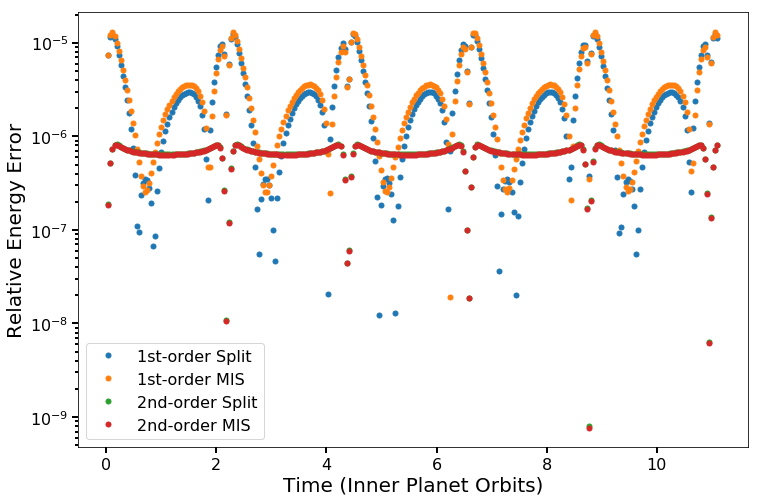

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Eerr1st, '.', label='1st-order Split')
ax.plot(times, Eerr1stmod, '.', label='1st-order MIS')
ax.plot(times, Eerr2nd, '.', label='2nd-order Split')
ax.plot(times, Eerr2ndmod, '.', label='2nd-order MIS')
ax.set_yscale('log')
ax.set_xlabel('Time (Inner Planet Orbits)')
ax.set_ylabel('Relative Energy Error')
ax.legend()
fig.savefig("modifiedintegrationschemes.pdf", bbox_inches='tight')